In [1]:
!pip install git+https://github.com/imanring/BSTPP.git

  Cloning https://github.com/imanring/BSTPP.git to /tmp/pip-req-build-8fn6ork4
  Running command git clone --filter=blob:none --quiet https://github.com/imanring/BSTPP.git /tmp/pip-req-build-8fn6ork4
  Resolved https://github.com/imanring/BSTPP.git to commit 54ac69a7a37699f164584f3761973062fc9e7653
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for BSTPP, since package 'wheel' is not installed.
  Running setup.py install for BSTPP ... done


In [1]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np

In [2]:
A = np.array([[3,15.5],[4,16.5]])
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
model_name = 'hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,
                            spatial_cov='data/inc_spatial_cov.csv',cov_grid_size=(0.5,0.5),
                            cov_names = column_names,
                            a_0=dist.Normal(0,5)
                           )

In [3]:
import sys
from bstpp import inference_functions
from bstpp import utils
sys.modules['inference_functions'] = inference_functions
sys.modules['utils'] = utils

import pickle
pre_run = True
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc(num_warmup=500,num_samples=1000,output_file=f'output/{model_name}/output.pkl')

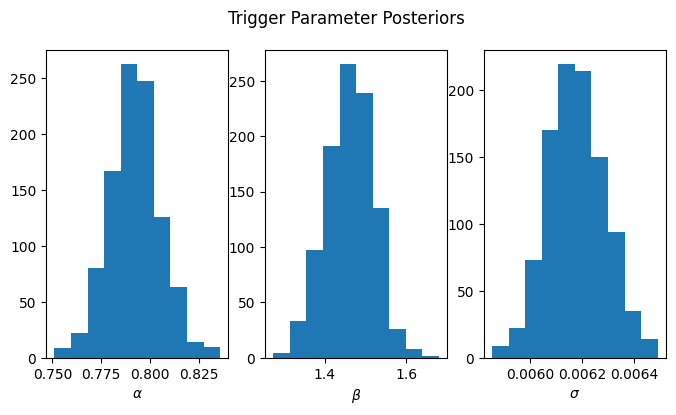

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.792135,0.013165,60.170200,0.0,0.766795,0.818655
beta,1.462121,0.057466,25.443113,0.0,1.348562,1.566254
sigma,0.006178,0.000109,56.548809,0.0,0.005972,0.006405


In [4]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

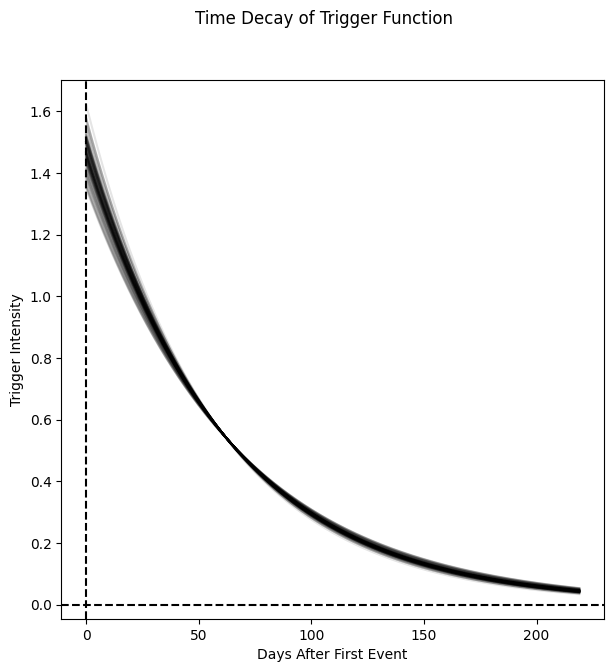

Mean trigger time: 62.57 days


In [5]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

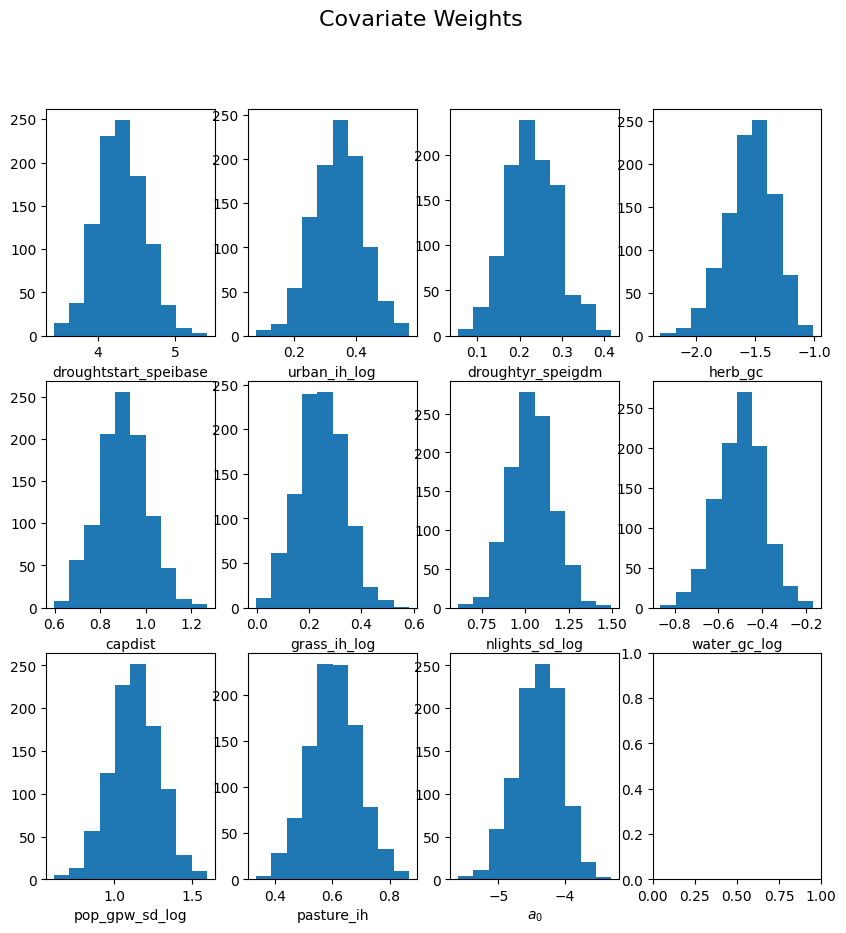

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,4.302984,0.305537,14.083326,0.000000e+00,3.705304,4.904547
urban_ih_log,0.342801,0.079758,4.298030,1.723228e-05,0.192258,0.501084
droughtyr_speigdm,0.230332,0.060860,3.784611,1.539488e-04,0.119518,0.355229
herb_gc,-1.539919,0.204606,-7.526260,5.218048e-14,-1.979717,-1.179485
capdist,0.901265,0.106708,8.446096,0.000000e+00,0.693985,1.115439
grass_ih_log,0.246746,0.088533,2.787050,5.319026e-03,0.072065,0.419774
nlights_sd_log,1.036318,0.124945,8.294169,1.110223e-16,0.805495,1.280154
water_gc_log,-0.497516,0.105864,-4.699586,2.606890e-06,-0.718159,-0.291534
pop_gpw_sd_log,1.132172,0.155079,7.300621,2.864375e-13,0.831008,1.425399
pasture_ih,0.606247,0.087623,6.918786,4.555356e-12,0.433513,0.782097


In [10]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

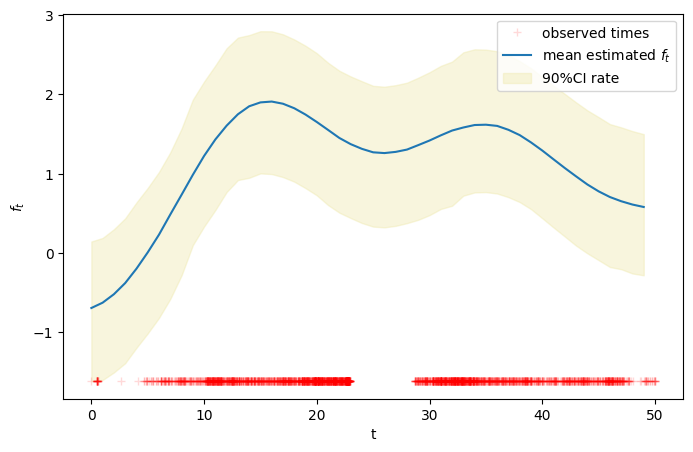

In [5]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

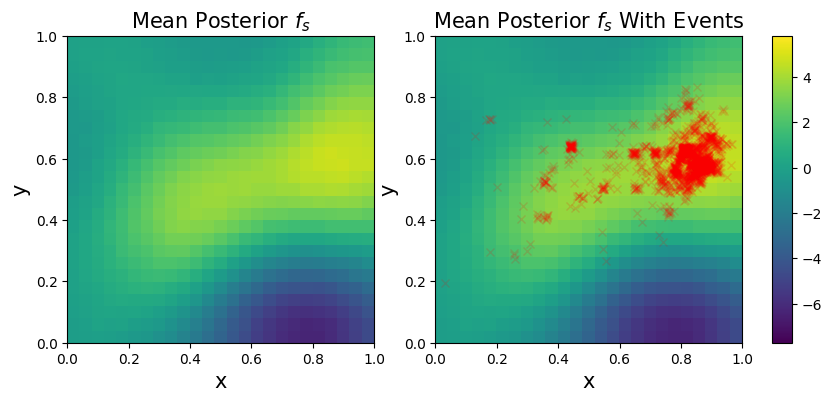

In [6]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

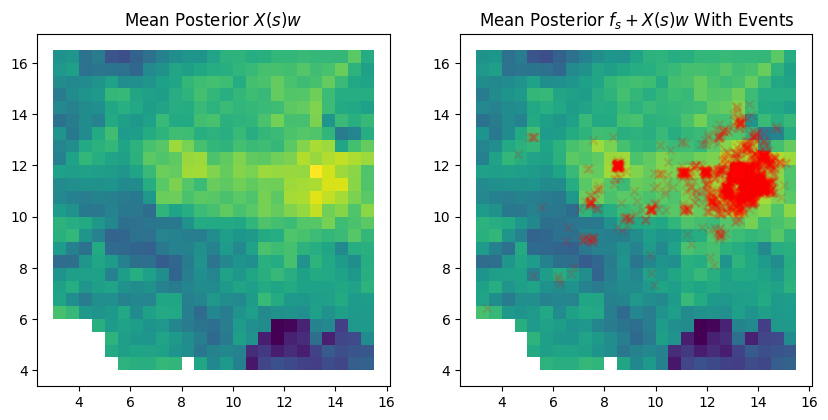

In [4]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)